In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch as pt
import numpy as np

from allocineutil import get_rating_class, get_rating_value

# To get the PDF run:
# jupyter nbconvert Rapport.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to pdf

train = pd.read_pickle("dataset/train.bin.zst")
test = pd.read_pickle("dataset/test.bin.zst")
dev = pd.read_pickle("dataset/dev.bin.zst")

# Description du fichier
## Information general


Sur le fichier train.xml, nous avons 665962 ligne, 100400 ligne sur le dev.xml et 85847 ligne sur le fichier test

On peut trouver des données vide dans le train, on trouve 12 ligne où il n’y a pas de commentaire, 2 sur le corpus dev.

En étudiant le “corpus” on voit que certain, il y est plus d'id_user que de nom soient que plussent user on le même nom.


Nous avons 3 fichiers train.xml dev.xml et test.xml, il possède différentes colonnes/attribue
- movie: On a ici l’id du film lié au site AlloCiné
- name: On a ici les noms des utilisateurs qui ont posté le commentaire
- user_id: On a ici l’id de l’utilisateur sur AlloCiné
- note: ces champs n’est évidemment pas présent dans le fichier test.xml
- commentaire: On a ici le commentaire laissé par l’utilisateur

In [2]:
max_comment_train = train["commentaire"].str.split("\\s+")
max_comment_dev = dev["commentaire"].str.split("\\s+")
max_comment_test = test["commentaire"].str.split("\\s+")


On trouve dans le fichier d'entrainement des commentaires étant vide ou allant a 5302 mots pour un seul commentaire

In [ ]:
max_comment_train.str.len().max()


5302

In [ ]:
max_comment_dev.str.len().max()


4187

In [ ]:
max_comment_test.str.len().max()


3689

Pour les commentaires vide on en trouve 12 pour l'entrainement et 2 pour le dev et 1 pour le test

On peut aussi noter qu'il y a 35 344 id d'utilisateur différent, mais seulement 32044 noms d'utilisateur différent et que donc un nom peut signifier plusieurs utilisateurs

In [ ]:
len(dev["name"].unique())

32044

In [ ]:
len(dev["user_id"].unique())

35344

# Approfondissements des informations
## Répartition des notes dans nos données

Nous avons cherché à voir comment les notes étaient repartie dans nos jeux de données et si elle était répartie de la même façon pour le jeu d'entrainement et de développement

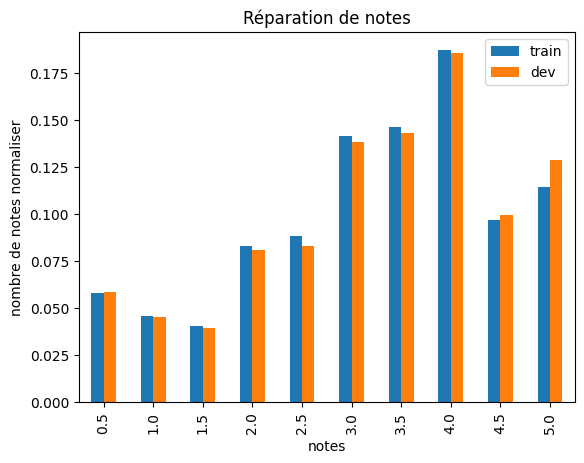

In [ ]:
note_values = pd.DataFrame()
note_values["train"] = train["note"].value_counts(normalize=True).sort_index()
note_values["dev"] = dev["note"].value_counts(normalize=True).sort_index()
note_values.plot(kind="bar",title="Réparation de notes",xlabel="notes",ylabel="nombre de notes normaliser")
plt.show()

# three_classes = pd.DataFrame()
# three_classes["train"] = train["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
# three_classes["dev"] = dev["note"].transform(get_rating_class).value_counts(normalize=True).sort_index()
# three_classes.plot(kind="bar")  


## Distribution des notes de film

On peut voir que la répartition des notes pour un film avec plus de 100 review. Sera souvent entre 3 et 4,5. Sauf exception ou là, on sera alors plus entre 0,5 et 2,0.

<AxesSubplot:title={'center':'Rating distribution for 20 randomly sampled movies (with >100 reviews)'}, ylabel='movie'>

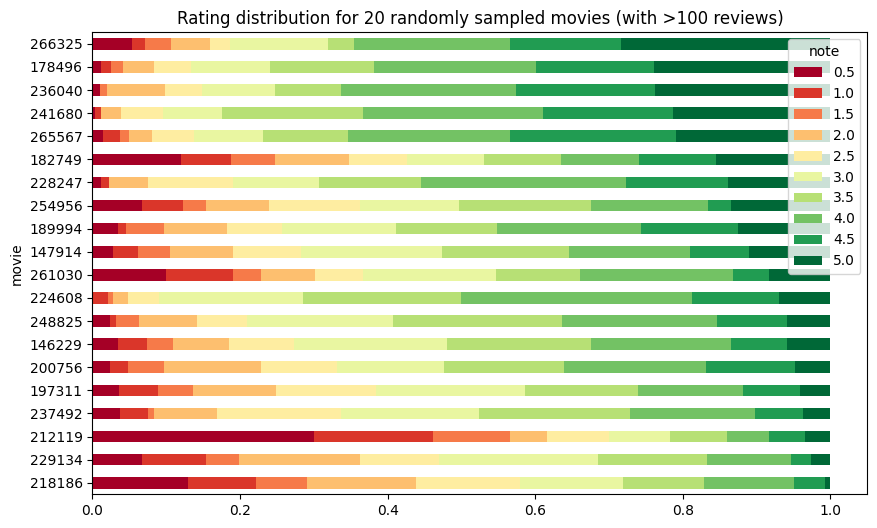

In [ ]:
film_subset = dev

# remove movies with less than 100 review
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(100)]

# make a table from the normalized frequency of each rating for each movie
film_subset = film_subset.groupby("movie").note.value_counts(normalize=True).unstack()

# sample 20 movies and create stacked horizontal bar plots of the ratings for each movie using a green-to-red colormap, sorted by the frequency of the 5-star rating
film_subset.sample(20).sort_values(5, ascending=True).plot.barh(title="Rating distribution for 20 randomly sampled movies (with >100 reviews)", stacked=True, colormap="RdYlGn", figsize=(10, 6))

## Note moyenne du film par rapport au nombre de critiques

On peut voir que malgré quelque exception, on peut voir que plus, il y a de review plus, on tend vers une bonne note.

Text(0.5, 0, 'Average rating')

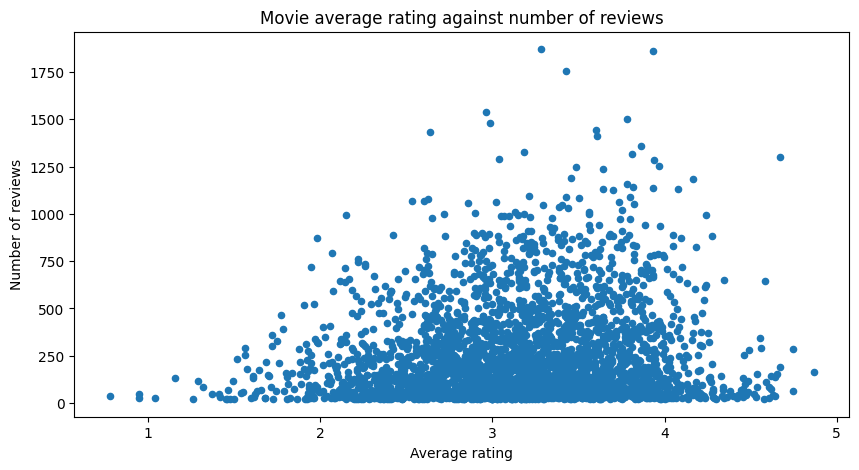

In [ ]:
# plot movies average rating against number of reviews
film_subset = pd.concat([train, dev])

# remove movies with less than 20 reviews
film_subset = film_subset[film_subset.groupby("movie")["movie"].transform("count").ge(20)]

film_subset = film_subset.groupby("movie").agg({"note": "mean", "movie": "count"})
film_subset.plot.scatter(y="movie", x="note", title="Movie average rating against number of reviews", figsize=(10, 5))
plt.ylabel("Number of reviews")
plt.xlabel("Average rating")

## Répartition des notes par rapport au nombre d'avis des utilisateurs

On peut voir avec cette répartition, que plus le nombre de notes mit par un utilisateur est bas, plus les notes sont extrêmes que ce soit en positivement ou négativement. Mais que plus une personne donnée de notes, plus elle tend à être positive, mais aussi disperser entre 2 et 4,5. 

Text(0, 0.5, 'amount of reviews (non-linear scale!)')

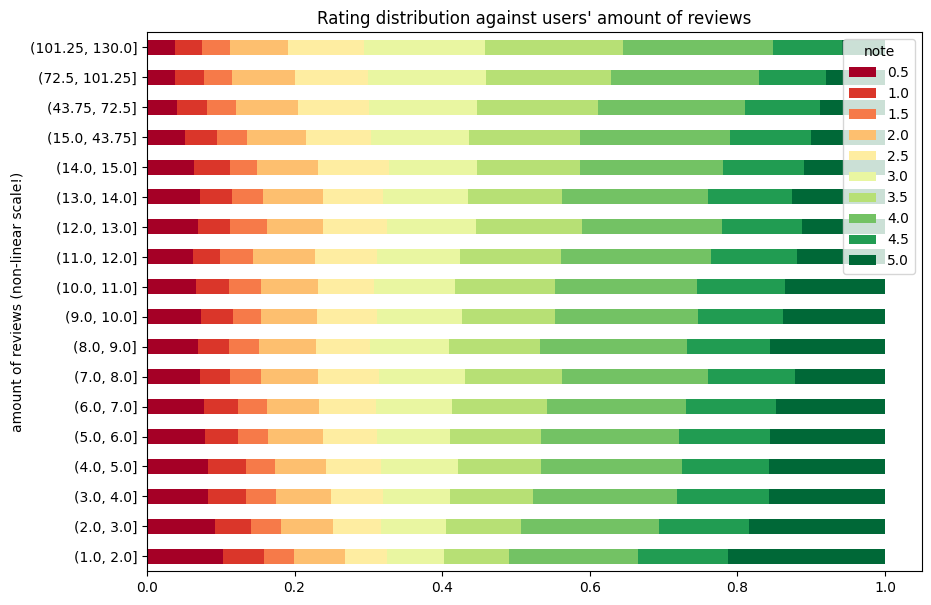

In [ ]:
# bin users by the number of reviews they have written into 10 bins
user_subset = train
bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh(title="Rating distribution against users' amount of reviews", stacked=True, colormap="RdYlGn", figsize=(10, 7))
plt.ylabel("amount of reviews (non-linear scale!)")

Sur les données de développement, on peut voir comparé à ceux du fichier d'entrainement

Text(0, 0.5, 'amount of reviews (non-linear scale!)')

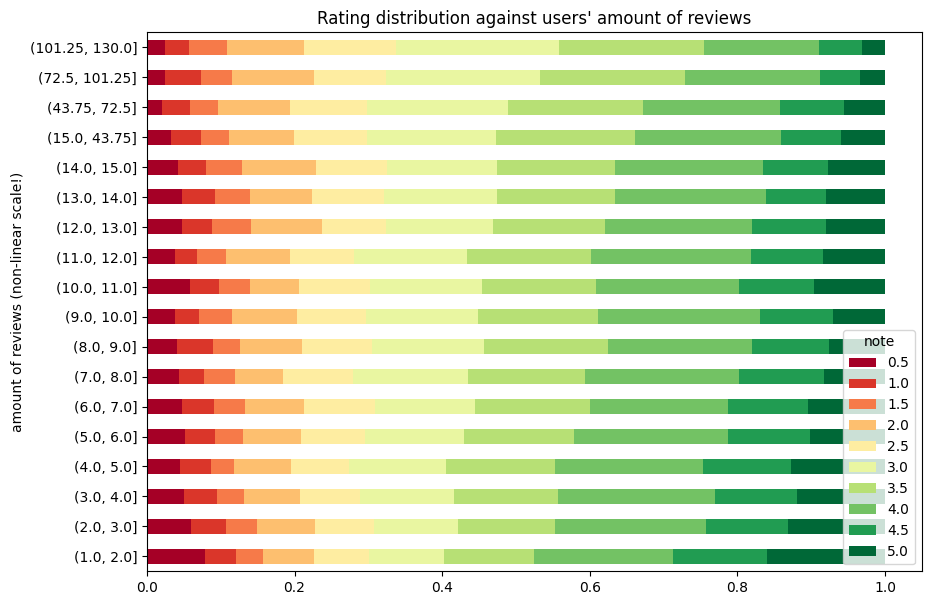

In [ ]:
# bin users by the number of reviews they have written into 10 bins
user_subset = dev
bins = np.concatenate((np.linspace(1, 14, 14), np.linspace(15, 130, 5)))

user_subset["bin"] = pd.cut(user_subset.groupby("user_id")["user_id"].transform("count"), bins)

# make a table from the normalized frequency of each rating for each user bin
user_subset = user_subset.groupby("bin").note.value_counts(normalize=True).unstack()

# create stacked horizontal bar plots of the ratings for each user bin using a green-to-red colormap
user_subset.plot.barh(title="Rating distribution against users' amount of reviews", stacked=True, colormap="RdYlGn", figsize=(10, 7))
plt.ylabel("amount of reviews (non-linear scale!)")

## Corrélation avec la notation

On peut voir que le nombre de phrases dans un commentaire et lier à une note négative, tout comme le nombre de mots.

On peut voir un fort corrélation entre les point et une note négative ce qui peut faire rappeler au point des phrases comme vus précédemment. Mais cela pourrait être dû aussi au trois petits points pour faire des listes ou des citations lier au film.

Les points d'interrogations sont aussi corrélés négativement, surement lier au questionnement sur les films ou alors sur une incompréhension de celui-ci.

Il n'y a que les majuscules et les point d'exclamation qui sont corrélés faiblement et fortement positivement. 

<AxesSubplot:title={'center':'Correlation with rating'}>

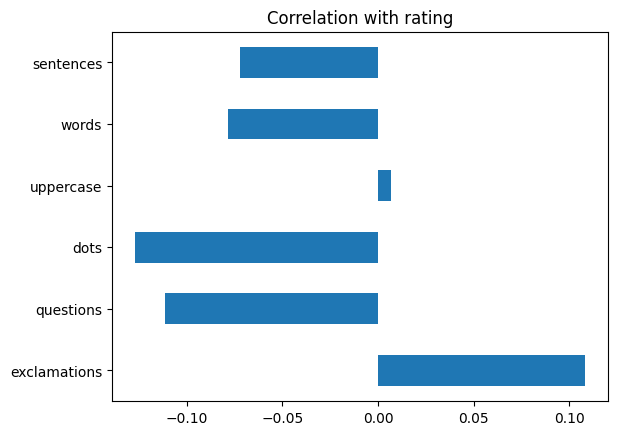

In [ ]:
# count the amount of exclamation marks in each review
dev["exclamations"] = dev["commentaire"].transform(lambda text: text.count("!"))

# count the amount of question marks in each review
dev["questions"] = dev["commentaire"].transform(lambda text: text.count("?"))

# count the number of dots in each review
dev["dots"] = dev["commentaire"].transform(lambda text: text.count("."))

# count the amount of uppercase words in each review
dev["uppercase"] = dev["commentaire"].transform(lambda text: sum(1 for word in text.split() if word.isupper()))

# count the amount of words in each review
dev["words"] = dev["commentaire"].transform(lambda text: len(text.split()))

# count the number of sentences in each review
dev["sentences"] = dev["commentaire"].transform(lambda text: len(list(word for word in text.split(".") if len(word) != 0)))

# plot the correlation between every feature and the rating
dev[["exclamations", "questions", "dots", "uppercase", "words", "sentences", "note"]].corr("spearman").note.drop("note").plot.barh(title="Correlation with rating")